In [65]:
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv('../../data/ST001937_AN003150.csv')

Dropping not needed columns and renaming the Phenotypes column to labels

In [66]:
df = df.drop(['Sample ID', 'RAW_FILE_NAME'], axis=1)

# removing phenotypes that HEalthy Controls
df = df[df['Phenotypes'] != 'Healthy Controls']
df['Phenotypes'] = df['Phenotypes'].apply(lambda x: 0 if x == 'Healthy Controls' else 0 if x == 'Maligant SPNS' else 1)
df['Phenotypes'].value_counts()

0    723
1    157
Name: Phenotypes, dtype: int64

Filling missing values with the mean

In [67]:
df.fillna(df.mean(), inplace=True)

Performing extreme gradient boost model

Average Accuracy (k=10): 0.81
Average AUC Score (k=10): 0.51


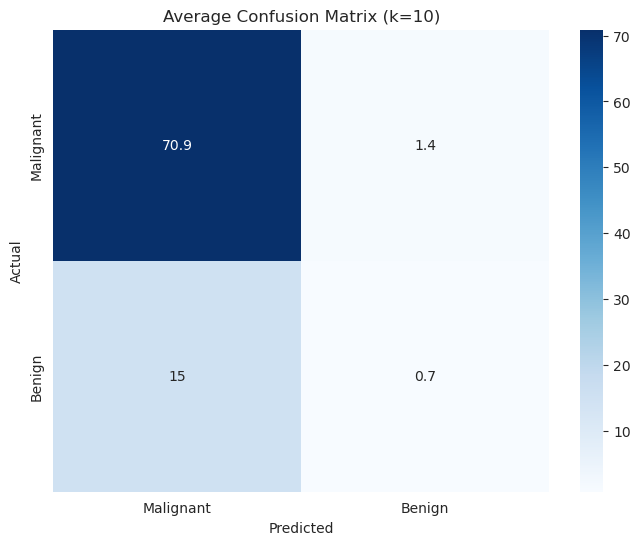

In [68]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import seaborn as sns

# Split the data into features (X) and target variable (y)
X = df.drop('Phenotypes', axis=1)
y = df['Phenotypes']

# Perform k-fold cross-validation and visualize results
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []
conf_matrices = []
auc_scores = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xg_clf = xgb.XGBClassifier(objective='binary:logistic', seed=42)
    xg_clf.fit(X_train, y_train)

    y_pred = xg_clf.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))
    conf_matrices.append(confusion_matrix(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_pred, multi_class='ovr'))

avg_accuracy = sum(accuracies) / len(accuracies)
avg_conf_matrix = sum(conf_matrices) / len(conf_matrices)
avg_auc_score = sum(auc_scores) / len(auc_scores)

print(f"Average Accuracy (k={k}): {avg_accuracy:.2f}")
print(f"Average AUC Score (k={k}): {avg_auc_score:.2f}")
plt.figure(figsize=(8, 6))
sns.heatmap(avg_conf_matrix, annot=True, fmt="g", cmap="Blues", xticklabels=['Malignant', 'Benign'], yticklabels=['Malignant', 'Benign'])
plt.title(f"Average Confusion Matrix (k={k})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()